In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
from copulas import *
import ndtest # bivariate Kolmogorov-Smirnov

## download index data

In [3]:
from pandas_datareader import data
import yfinance as yfin
def get(tickers, start, end):
    def multiple(ticker):
        return yfin.download(ticker, start, end, progress=False)
    datas = map(multiple, tickers)
    return pd.concat(datas, keys=tickers,names=['Ticker', 'Date'])

In [4]:
tickers = ["^GSPC","^RUT"]
start = pd.to_datetime('2018-01-01')
end = pd.to_datetime('2020-12-31')
df = get(tickers, start, end)
adj_close = df.reset_index().pivot('Date','Ticker','Adj Close')
returns = np.log(adj_close).diff().dropna()
returns

C:\Users\ldw\AppData\Local\Temp\ipykernel_18840\2034766826.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  adj_close = df.reset_index().pivot('Date','Ticker','Adj Close')


Ticker,^GSPC,^RUT
Date,,
2018-01-03,0.006378,0.001657
2018-01-04,0.004021,0.002020
2018-01-05,0.007009,0.002754
2018-01-08,0.001661,0.001153
2018-01-09,0.001302,-0.001096
...,...,...
2020-12-23,0.000746,0.008617
2020-12-24,0.003530,-0.001571
2020-12-28,0.008685,-0.003850


<Axes: xlabel='Date'>

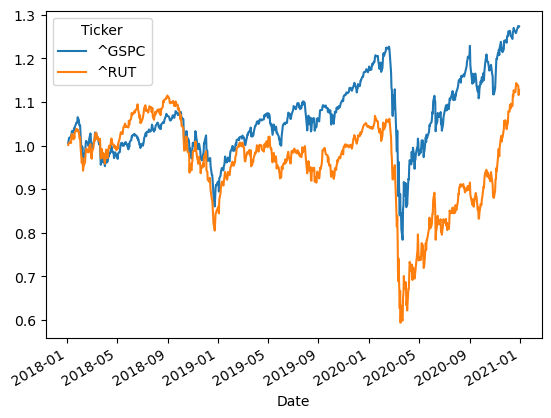

In [5]:
(returns+1).cumprod().plot()

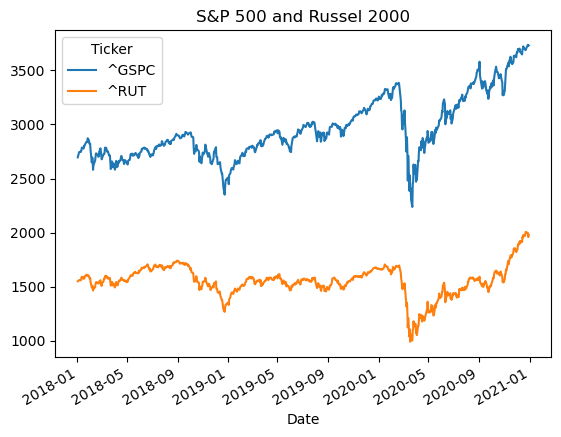

In [6]:
adj_close.plot()
plt.title('S&P 500 and Russel 2000')
plt.show()

## Kendall’s rank correlation coefficient (Kendall’s tau)

In [7]:
stats.kendalltau(returns['^GSPC'], returns['^RUT'])[0]

0.6608978073530624

Kendall’s rank correlation coefficient (Kendall’s tau) of these two indices is high.  
Maybe we can form a trding strategy using these two indices.

## fit marginal distributions to log-returns data

Now we can try and fit marginal distributions to log-returns data. I will try fitting four parametric distributions: normal, Student’s t, logistic and extreme. The selection will be made based on Akaike Information Criterion (AIC). For selected distribution I will also compute Bayesian Information Criterion (BIC) and p-value of Kolmogorov-Smirnov goodness-of-fit test.

In [8]:
marginals_df = pd.DataFrame(columns=['Stock','Distribution', 'AIC', 'BIC', 'KS_pvalue'])
for stock in tickers:
    data = returns[stock]
    dists = ['Normal', "Student's t", 'Logistic', 'Extreme']
    best_aic = np.inf
    for dist,name in zip([stats.norm, stats.t, stats.genlogistic, stats.genextreme], dists):
        params = dist.fit(data)
        dist_fit = dist(*params)
        log_like = np.log(dist_fit.pdf(data)).sum()
        aic = 2*len(params) - 2 * log_like
        bic = len(params) * np.log(len(data)) - 2 * log_like
        ks_pval = stats.kstest(data, dist_fit.cdf, N=100)[1]
        new_row = pd.DataFrame([[stock, name, aic, bic, ks_pval]], columns=marginals_df.columns)
        marginals_df = pd.concat([marginals_df, new_row], ignore_index=True)
marginals_df = marginals_df.set_index(['Stock','Distribution'])
#marginals_df.to_csv('fitting_results.csv')
marginals_df

AIC          BIC      KS_pvalue
Stock Distribution                                         
^GSPC Normal       -4210.475561 -4201.224777   1.370371e-13
      Student's t  -4624.470902 -4610.594724   6.603174e-01
      Logistic     -4506.750495 -4492.874318   9.112091e-04
      Extreme      -1668.596746 -1654.720569  1.008600e-176
^RUT  Normal       -3915.364402 -3906.113617   1.780717e-10
      Student's t  -4259.375703 -4245.499526   7.547674e-01
      Logistic     -4170.111517 -4156.235340   5.592771e-03
      Extreme      -1669.348272 -1655.472095  7.087019e-164

In [9]:
marginals_df = pd.DataFrame(index=tickers, columns=['Distribution', 'AIC', 'BIC', 'KS_pvalue'])
for stock in tickers:
    data = returns[stock]
    dists = ['Normal', "Student's t", 'Logistic', 'Extreme']
    best_aic = np.inf
    for dist,name in zip([stats.norm, stats.t, stats.genlogistic, stats.genextreme], dists):
        params = dist.fit(data)
        dist_fit = dist(*params)
        log_like = np.log(dist_fit.pdf(data)).sum()
        aic = 2*len(params) - 2 * log_like
        if aic<best_aic:
            best_dist = name
            best_aic = aic
            best_bic = len(params) * np.log(len(data)) - 2 * log_like
            ks_pval = stats.kstest(data, dist_fit.cdf, N=100)[1]
    marginals_df.loc[stock] = [best_dist, best_aic, best_bic, ks_pval]
marginals_df

,Distribution,AIC,BIC,KS_pvalue
^GSPC,Student's t,-4624.470902,-4610.594724,0.660317
^RUT,Student's t,-4259.375703,-4245.499526,0.754767


For all the stocks above Student’s t distribution was selected. P-values of Kolmogorov-Smirnov test are quite large, meaning that we can’t reject the null hypothesis that tested distributions are the same. That allows us to conclude that selected parametric distributions model empirical data sufficiently well.

## Copula

fit different Copula modelsand check their goodness of fit

In [10]:
pair = ('^GSPC','^RUT')
s1,s2 = pair
copulas_df = pd.DataFrame(columns=['parameter', 'aic', 'bic', 'KS_pvalue'])

# fit marginals
params_s1 = stats.t.fit(returns[s1])
dist_s1 = stats.t(*params_s1)
params_s2 = stats.t.fit(returns[s2])
dist_s2 = stats.t(*params_s2)
# apply probability integral transform
u = dist_s1.cdf(returns[s1])
v = dist_s2.cdf(returns[s2])


#for copula in [GaussianMultivariate()]:
for copula in [GaussianCopula(), ClaytonCopula(), GumbelCopula(), FrankCopula(), JoeCopula()]:
    copula.fit(u,v)
    L = copula.log_likelihood(u,v)
    aic = 2 * copula.num_params - 2 * L
    bic = copula.num_params * np.log(len(u)) - 2 * L
    copula_name = copula.name
    
    # calculate KS-pvalue
    smp = copula.sample(size=len(u)) # generate sample from fit copula
    s_u = smp[:,0]
    s_v = smp[:,1]
    ks_pval = ndtest.ks2d2s(u,v,s_u,s_v)
    
    if isinstance(copula, ArchimedeanCopula):
        best_param = copula.alpha
    else:
        best_param = copula.rho
    #print([copula_name, best_param, aic, bic, ks_pval])
    copulas_df.loc[copula_name] = [best_param, aic, bic, ks_pval]
copulas_df.to_csv('Copula_result.csv')
copulas_df

,parameter,aic,bic,KS_pvalue
Gaussian,0.861459,-1066.236551,-1061.611158,0.116044
Clayton,2.810042,-948.964923,-944.339530,0.083661
Gumbel,2.910326,-1023.619433,-1018.994040,0.457421
Frank,9.696064,-926.088563,-921.463170,0.111591
Joe,3.482818,-812.228801,-807.603409,0.001077


Gaussian Copula has the lowest AIC and BIC. Therefore, we will choose Gaussian Copula model to capture non-linear relationship between two stock indices.

## Pairs Trading

In [11]:
tickers = ["^GSPC","^RUT"]
s1 = "^GSPC"
s2 = "^RUT"
start = pd.to_datetime('2010-01-01')
end = pd.to_datetime('2023-10-22')
df = get(tickers, start, end)
adj_close = df.reset_index().pivot('Date','Ticker','Adj Close')
returns_test = np.log(adj_close).diff().dropna()
returns_test

C:\Users\ldw\AppData\Local\Temp\ipykernel_18840\1403863.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  adj_close = df.reset_index().pivot('Date','Ticker','Adj Close')


Ticker,^GSPC,^RUT
Date,,
2010-01-05,0.003111,-0.002518
2010-01-06,0.000545,-0.000846
2010-01-07,0.003993,0.006282
2010-01-08,0.002878,0.004026
2010-01-11,0.001745,-0.000885
...,...,...
2023-10-16,0.010539,0.015779
2023-10-17,-0.000098,0.010811
2023-10-18,-0.013490,-0.021312


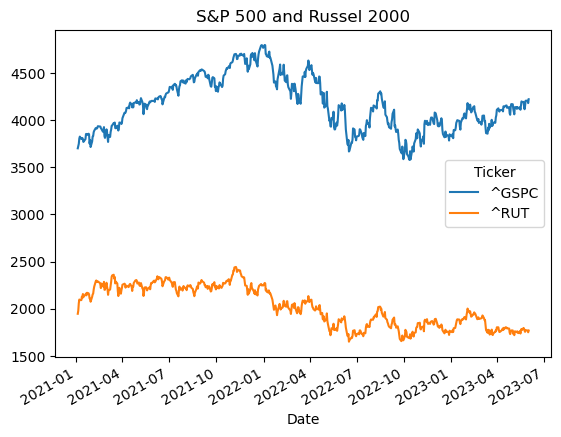

In [12]:
adj_close.loc['2021-1-01':'2023-6-01',:].plot()
plt.title('S&P 500 and Russel 2000')
plt.show()

calculate conditional probability based on Copula joint distribution

In [13]:
def get_prob_trading(data_source,fitting_period,predicting_period,start,end):
    '''
    calculate conditional probability based on Copula joint distribution.
    '''
    s1,s2 = data_source.columns
    all_time_index = data_source.index
    trading_time_index = data_source.loc[start:end].index
    end_loc = all_time_index.get_loc(trading_time_index[-1])
    prob_s1 = []
    prob_s2 = []
    for t in trading_time_index[::predicting_period]:
        start_loc = all_time_index.get_loc(t)
        fitting_return = data_source.iloc[start_loc-fitting_period:start_loc]
        predicting_return = data_source.iloc[start_loc:min(start_loc+predicting_period,end_loc+1)]
        
        # fit marginals
        params_s1 = stats.t.fit(fitting_return[s1])
        dist_s1 = stats.t(*params_s1)
        params_s2 = stats.t.fit(fitting_return[s2])
        dist_s2 = stats.t(*params_s2)

        # transform marginals
        u = dist_s1.cdf(fitting_return[s1])
        v = dist_s2.cdf(fitting_return[s2])

        copulas = GaussianCopula()
        copulas.fit(u,v)

        for u,v in zip(dist_s1.cdf(predicting_return[s1]), dist_s2.cdf(predicting_return[s2])):
            prob_s1.append(copulas.cdf_u_given_v(u,v))
            prob_s2.append(copulas.cdf_v_given_u(u,v))

    probs_trade = pd.DataFrame(np.vstack([prob_s1, prob_s2]).T, index=trading_time_index, columns=[s1, s2])
    return probs_trade

conduct pairs trading based on conditional probability

In [14]:
def pair_strategy(data_source,probs_trade,cl,cl_close):
    s1 = probs_trade.columns[0]
    s2 = probs_trade.columns[1]
    positions = pd.DataFrame(index=probs_trade.index, columns=probs_trade.columns)
    long = False
    short = False
    for t in positions.index:    
        # if long position is open
        if long:
            if (probs_trade.loc[t][s1] > (1-cl_close)) or (probs_trade.loc[t][s2] < cl_close):
                positions.loc[t] = [0,0]
                long = False
            else:
                positions.loc[t] = [1,-1]

        # if short position is open
        elif short:
            if (probs_trade.loc[t][s1] < cl_close) or (probs_trade.loc[t][s2] > (1-cl_close)):
                positions.loc[t] = [0,0]
                short = False
            else:
                positions.loc[t] = [-1,1]

        # if no positions are open
        else:
            if (probs_trade.loc[t][s1] < (1-cl)) and (probs_trade.loc[t][s2] > cl):
                # open long position
                positions.loc[t] = [1,-1]
                long = True
            elif (probs_trade.loc[t][s1] > cl) and (probs_trade.loc[t][s2] < (1-cl)):
                # open short positions
                positions.loc[t] = [-1,1]
                short = True
            else:
                positions.loc[t] = [0,0]

    # calculate returns
    returns_trade = data_source.loc[probs_trade.index]
    algo_returns = {}
    algo_ret = (returns_trade * positions.shift(1)).sum(axis=1)
    algo_returns['pair'] = algo_ret
    returns_df = pd.DataFrame.from_dict(algo_returns)
    returns_df = np.exp(returns_df) - 1 # convert log-returns to simple returns
    total_ret = returns_df.sum(axis=1) / len(returns_df.columns) * 2 # double capital (from short positions)

    a = pd.DataFrame(data={'Pairs Trading':np.nancumprod(total_ret + 1),s1:np.nancumprod(returns_trade[s1] + 1),s2:np.nancumprod(returns_trade[s2] + 1)},index=probs_trade.index)
    return a

strategy performance

In [15]:
fitting_period = 500
predicting_period = 100
start = '2021-1-01'
end = '2023-6-01'
probs_trade = get_prob_trading(returns_test,fitting_period,predicting_period,start,end)

<Axes: xlabel='Date'>

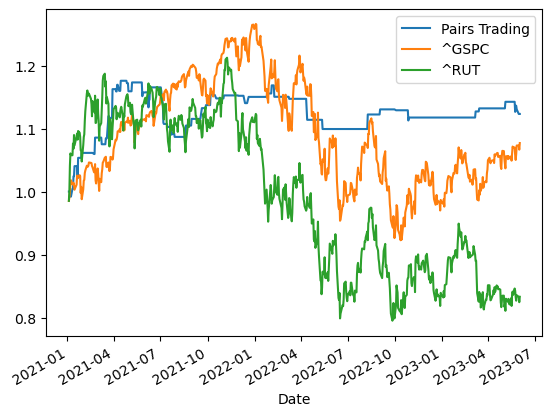

In [16]:
cl = 0.90
cl_close = 0.70
pair_strategy(returns_test,probs_trade,cl,cl_close).plot()

Text(0.5, 1.0, 'the performance of Pairs Trading compared with indexes')

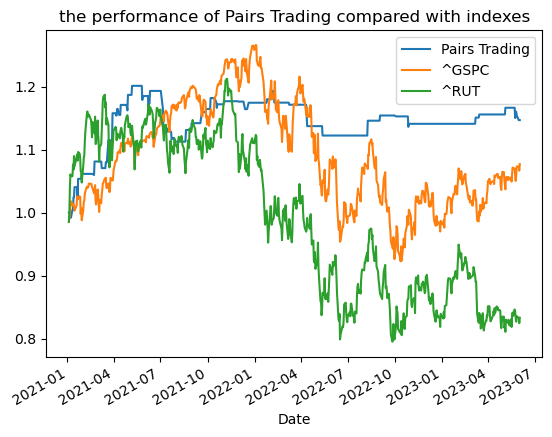

In [17]:
cl = 0.90
cl_close = 0.65
pair_strategy(returns_test,probs_trade,cl,cl_close).plot()
plt.title('the performance of Pairs Trading compared with indexes')

In [18]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD

In [19]:
total_ret = pair_strategy(returns_test,probs_trade,0.9,0.65)
metrics = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'MaxDD'])
metrics.loc['Pairs Trading'] = calculate_metrics(total_ret['Pairs Trading'])
metrics.loc['^GSPC'] = calculate_metrics(total_ret['^GSPC'])
metrics.loc['^RUT'] = calculate_metrics(total_ret['^RUT'])
metrics.to_csv('strategy_performance.csv')
metrics

,Total return,APR,Sharpe,MaxDD
Pairs Trading,0.146636,0.058451,0.759900,-0.073695
^GSPC,0.093236,0.037701,0.291503,-0.271104
^RUT,-0.154529,-0.067316,-0.163180,-0.344234
